# Neural Networks for Data Science Applications (2019/2020)
## Final exam

* **Student**: Joanna Broniarek (1868264).
* **Reference paper / topic**: Changhee Han, Hideaki Hayashi et al., "GAN-BASED SYNTHETIC BRAIN MR IMAGE GENERATION" [http://www.nlab.ci.i.u-tokyo.ac.jp/pdf/isbi2018.pdf] 



## Part 1: Report

*The idea was to implement one of the GAN models proposed in the paper. Hence, I implemented and trained a DCGAN model (Deep convolutional generative adversarial networks) on 3D MRI T1-weighted images. As a dataset I used the images from the BRATS 2019 dataset.*

#### 1. Example of the ORIGINAL  images used for training the GANs:

<img src="docs/example.png" width="600" height="600">

### 2. Preprocessing

* I selected the slices from 50 to 125 among the whole 155 slices to omit initial/final ones, since they convey a negligible amount of useful information and could affect the training.

* The images are resized to 64 × 64 from 240 x 240

* I normalised the images to zero mean/unit std dev

### 3. TFRecords
* For most deep learning problems on image volumes, the database of training examples is too large to fit into memory. The TFRecords format allows to serialise training examples and store them on disk with quick access, i.e. parallel data reads. As it required to store another copy of the entire training database, I used the Google Cloud Platform resources to overcome this issue.

### 4. Model

DCGAN model is based on a convolutional architecture for unsupervised learning. It has two main components: Generator and Disriminator.

Implementation Details:

* batch size = 16 (due to GPU limitations)
* kernel of size 4
* padding = 'same'
* strides = (1, 2, 2)

--------------

#### Discriminator
* four 3DConv layers
* four Dropout to avoid overconfidence
* Leaky Relu act.
* one Dense layer

* ADAM optimizer with initial lr=5e-5

--------------------

#### Generator
* one Dense layer + Elu act.
* four Conv3DTranspose layers + ReLU act.
* ADAM optimizer with initial lr=5e-4

<img src="docs/dcgan.png" width="800" height="600">
Fig. Example of DCGAN architecture (source: https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html) 

### 5. Losses

#### Generator Loss - measures how well it was able to cheat on the discriminator.

* **Cross Entropy Loss**.

* **Label Smoothing** - Instead of 0 for a negative class it assigns a random integer in range (0, 0.3)

-------------

#### Discriminator Loss - measures how well the discriminator was able to distinguish real and fake images. 

* **Cross Entropy Loss**.
* **Added noise to labels** +  **Label Smoothing** - Instead of 1 for a positive class it assigns a random integer in range (0.7, 1)

## Part 2: External libraries

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import argparse

import logging
logging.getLogger('tensorflow').disabled = True

import tensorflow as tf
tf.get_logger().setLevel('ERROR')


import SimpleITK as sitk # to read .nii format data
import cv2 # to image preprocessing


from tensorflow.keras.layers import (Conv3D,
                                     Dense,
                                     Conv3DTranspose,
                                     Reshape,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Activation, 
                                     Flatten,
                                     Dropout)
from tensorflow.keras import Sequential
from tensorflow.keras.utils import Progbar


## I also used few snippets of code from tensorflow tutorials in order to build the TFRecord file:
## [https://www.tensorflow.org/tutorials/load_data/tfrecord]
## Copied Functions:  _float_feature, _bytes_feature, _decode

## Part 3: Code 

In [2]:
## Import my external functions
from create_data import *
from utils import *
from models import *

I decided to not to use notebook for a training. Instead I implemented and spliited my code into few external modules. Each of them has docs and comments to make the code cleaner and more organized. Modules:
* [**create_data.py**](create_data.py) - contains all functions needed to load images, preprocess them and to build the TFRecords file
* [**models.py**](models.py) - contains an implementation of generator, discriminator, losses and few additional functions used for i.e. label smoothing
* [**utils.py**](utils.py) - functions used for generating and plotting the synthetic images

Main Training module:
* [**train3D.py**](train3D.py) - contains the main training loop function with initialization of all the models, optimizers, checkpoints etc. You can find there also functions for parsing the arguments from terminal.

For training you can run the folllowing code in terminal:

```
$ python3 train3D.py
	--epochs 100
	--batch_size 16
	--lr_g 5e-4
	--lr_d 5e-5
	--rand_seed 42
```

----------------

**Plot of the Discriminator** (double click on output to zoom it)

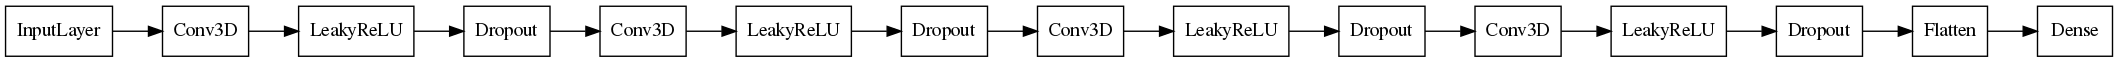

In [4]:
discriminator=discriminator3d()
tf.keras.utils.plot_model(discriminator, show_shapes = False, rankdir='LR', dpi=100, show_layer_names=False)

**Plot of the Generator**

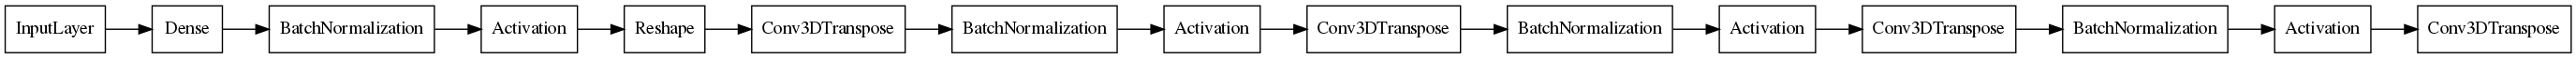

In [5]:
generator = generator3d()
tf.keras.utils.plot_model(generator, show_shapes = False, rankdir='LR', dpi=100, show_layer_names=False)

## Part 4 - Experimental evaluation

### Problems encountered while training
* Discriminator Loss was decreasing to zero values after few epochs
* Exploding Losses
* Memory issues (tfRecords, BufferSize)

### Used tricks to overcome the problems
* Batch Normalization
* Weight Initializer from Truncated Normal distribution
* tuning of the initial learning rates
* Decaying learning rates (ExponentialDecay)
* trying different Activation functions


### Plot of the Losses

In [5]:
%load_ext tensorboard

In [6]:
%tensorboard --logdir logs/2020-05-04_06:40:29/logs

Reusing TensorBoard on port 6006 (pid 8867), started 0:12:55 ago. (Use '!kill 8867' to kill it.)

###  Training : Sample run for 100 epochs

<img src="docs/mri.gif" width="600" height="600">

###  Generator - example of the synthetic sequence of images

Please, have in mind that I have not attached the pretrained model due to its size (~1 Gb).
However, I can run it during the exam, if need be. 

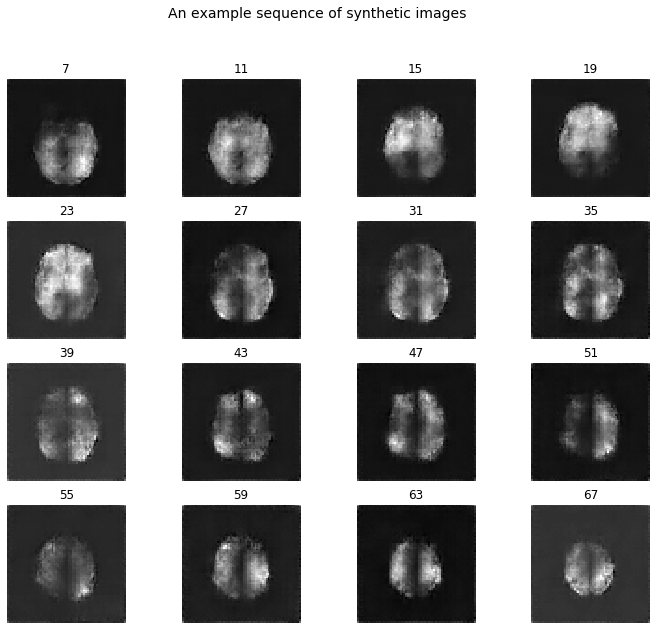

In [6]:
get_pretrained_model(generator)
np.random.seed(8)
noise_size = 100
test_noise = np.random.uniform(-1, 1, size=(1, noise_size))
generate_image(generator, test_noise, show=True)

### Ideas of possible further improvements: 
1. More training epochs
2. Add some spatial augmentations i.e.:
    * Random deformations, (e.g. for mimicking differences in organ shape)
    * Rotations along axes, etc.